# Capstone Project

## Park Slope Parents Membership

For this portion of the project I'm going to be making a classification model to determine whether someone is likely to be a long term or short term member.

The first step is figuring out where that line is. 

Median membership is 2 years, which is also close to the threshold I saw was when many folks check out relative to their child's birth (22 months). This seems like the ideal choice.

I'll also be doing a cluster analysis, because I love those.

In [276]:
# Load libraries

from datetime import datetime, date, timedelta

# import matplotlib.pyplot as plt
# %matplotlib inline

# from IPython.display import HTML
# from matplotlib import cm as cm
# from mpl_toolkits.mplot3d import Axes3D
# from pandas.io import sql
# from sklearn import metrics
# from sklearn.cluster import DBSCAN
# from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
# from sklearn.decomposition import PCA 
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
# from sqlalchemy import create_engine
import csv
import numpy as np
import pandas as pd 
# import patsy
# import plotly.graph_objs as go
# import plotly.plotly as py
# from plotly.tools import FigureFactory as FF
# from plotly.graph_objs import graph_objs
# import psycopg2 as psy
# import scipy
# import seaborn as sns
# import sklearn
import statsmodels.api as sm
# py.sign_in('ajbentley', 'zjfu2vasav')
# plt.style.use('fivethirtyeight')
# wine_palette = sns.xkcd_palette(['dandelion', 'claret'])

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [277]:
# read in data

dfn = pd.read_csv("../../projects/psp/raw_data/PSP_data_4capstone.csv")
dfn.info()
dfn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14914 entries, 0 to 14913
Data columns (total 23 columns):
mem_no                14914 non-null object
address               14914 non-null object
city                  14914 non-null object
state                 14914 non-null object
zip                   14914 non-null int64
joined                14914 non-null object
exp_date              14914 non-null object
status                14914 non-null object
mem_type              14914 non-null object
last_renewal_date     14914 non-null object
gender                14914 non-null object
club_email            14914 non-null object
dup                   14914 non-null object
parent_status         14914 non-null object
kid_count             14914 non-null float64
kid1_bday             14914 non-null object
kid2_bday             14914 non-null object
join_reason           10144 non-null object
advice_grp            14914 non-null int64
classifieds           14914 non-null int64
classifieds_s

,mem_no,address,city,state,zip,joined,exp_date,status,mem_type,last_renewal_date,...,parent_status,kid_count,kid1_bday,kid2_bday,join_reason,advice_grp,classifieds,classifieds_spouse,tony_kids,discovered
0,00002,438_12th_street,brooklyn,NY,11215,2009-02-16,2020-02-15,Active,Lifetime Member,2009-02-16,...,Yes,2.0,4/14/85,4/14/85,dfs,1,1,1,Yes,A PSP member who is a friend/neighbor
1,00004,580_5th_street,brooklyn,NY,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,...,Yes,2.0,12/11/02,12/11/02,NaN,1,1,0,Yes,A PSP member I don't know told me about it
2,00101,502_13th_st,brooklyn,NY,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,...,Yes,2.0,1/1/01,1/1/01,no,1,1,0,No,Other
3,00118,1512_10th_ave,brooklyn,NY,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,...,Yes,2.0,5/17/02,9/14/04,This is a renewal,1,1,0,No,A PSP member who is a friend/neighbor
4,00121,434_13th_st,brooklyn,NY,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,...,Yes,2.0,10/5/01,7/31/07,"Yes, I'm in love with you, Susan Fox! :-)",1,1,0,Yes,A PSP member who is a friend/neighbor


In [278]:
# # not all types carried over from when the data was saved (datetime in particular, which
# # pleases me not at all).

dfn.joined = pd.to_datetime(dfn.joined, format='%Y/%m/%d')
dfn.exp_date = pd.to_datetime(dfn.exp_date, format='%Y/%m/%d')
dfn.last_renewal_date = pd.to_datetime(dfn.last_renewal_date, format='%Y/%m/%d')
dfn.kid1_bday = pd.to_datetime(dfn.kid1_bday, format='%m/%d/%y')
dfn.kid2_bday = pd.to_datetime(dfn.kid2_bday, format='%m/%d/%y')

In [279]:
# getting rid of address and join reason

dfn.drop(["address",'join_reason'], axis=1, inplace=True)

dfn.head()

,mem_no,city,state,zip,joined,exp_date,status,mem_type,last_renewal_date,gender,...,dup,parent_status,kid_count,kid1_bday,kid2_bday,advice_grp,classifieds,classifieds_spouse,tony_kids,discovered
0,00002,brooklyn,NY,11215,2009-02-16,2020-02-15,Active,Lifetime Member,2009-02-16,Female,...,NO,Yes,2.0,1985-04-14,1985-04-14,1,1,1,Yes,A PSP member who is a friend/neighbor
1,00004,brooklyn,NY,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,Female,...,NO,Yes,2.0,2002-12-11,2002-12-11,1,1,0,Yes,A PSP member I don't know told me about it
2,00101,brooklyn,NY,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,Female,...,YES,Yes,2.0,2001-01-01,2001-01-01,1,1,0,No,Other
3,00118,brooklyn,NY,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,Female,...,NO,Yes,2.0,2002-05-17,2004-09-14,1,1,0,No,A PSP member who is a friend/neighbor
4,00121,brooklyn,NY,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,Female,...,YES,Yes,2.0,2001-10-05,2007-07-31,1,1,0,Yes,A PSP member who is a friend/neighbor


In [280]:
# columns for joined month and year

dfn['join_year'] = dfn['joined'].dt.year
dfn['join_month'] = dfn['joined'].dt.month

# columns for exp_date year

dfn['exp_year'] = dfn['exp_date'].dt.year

# # columns for 1st kid's birth month and year
dfn['k1bday_year'] = dfn['kid1_bday'].dt.year
dfn['k1bday_month'] = dfn['kid1_bday'].dt.month

# # columns for 2nd kid's birth month and year
dfn['k2bday_year'] = dfn['kid2_bday'].dt.year
dfn['k2bday_month'] = dfn['kid2_bday'].dt.month


dfn.head()

,mem_no,city,state,zip,joined,exp_date,status,mem_type,last_renewal_date,gender,...,classifieds_spouse,tony_kids,discovered,join_year,join_month,exp_year,k1bday_year,k1bday_month,k2bday_year,k2bday_month
0,00002,brooklyn,NY,11215,2009-02-16,2020-02-15,Active,Lifetime Member,2009-02-16,Female,...,1,Yes,A PSP member who is a friend/neighbor,2009,2,2020,1985,4,1985,4
1,00004,brooklyn,NY,11215,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,Female,...,0,Yes,A PSP member I don't know told me about it,2009,4,2020,2002,12,2002,12
2,00101,brooklyn,NY,11215,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,Female,...,0,No,Other,2002,7,2014,2001,1,2001,1
3,00118,brooklyn,NY,11215,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,Female,...,0,No,A PSP member who is a friend/neighbor,2002,8,2017,2002,5,2004,9
4,00121,brooklyn,NY,11215,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,Female,...,0,Yes,A PSP member who is a friend/neighbor,2002,8,2019,2001,10,2007,7


In [281]:
# check dates for out of consideration range. basically for grandparents who are using their children's birth dates,
# not their grandchildren's. Org started in 2002 so will assume anything prior to 1990 will be out of range

dfn = pd.DataFrame(dfn.loc[dfn['k1bday_year'] >= 1995])
dfn = pd.DataFrame(dfn.loc[dfn['k2bday_year'] >= 1995])
dfn = pd.DataFrame(dfn.loc[dfn['k1bday_year'] < 2018])
dfn = pd.DataFrame(dfn.loc[dfn['k2bday_year'] < 2018])

In [282]:
# adding column for membership duration
# in order to convert the timedelta result I divided by 6.048E+14 which gives me weeks as integers (just trust me)

dfn['mem_duration'] = ((dfn['exp_date'] - dfn['joined'])/604800000000000).astype(int)

In [283]:
# creating dummies for over/under 2 years

# md of 1 == n is a long term member

md = []

for n in dfn.mem_duration:
    if n > 104:
        md.append(1)
    else:
        md.append(0)
        
md_s = pd.Series(md)

In [284]:
# concat long-short to dfn

dfn = pd.concat([dfn, md_s], axis=1)
dfn.rename (columns={0:"long_short"}, inplace=True)
dfn.drop([0], axis=0, inplace=True)
print dfn.info()
print " "
print dfn.describe()
dfn.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14912 entries, 1 to 14913
Data columns (total 30 columns):
mem_no                14591 non-null object
city                  14591 non-null object
state                 14591 non-null object
zip                   14591 non-null float64
joined                14591 non-null datetime64[ns]
exp_date              14591 non-null datetime64[ns]
status                14591 non-null object
mem_type              14591 non-null object
last_renewal_date     14591 non-null datetime64[ns]
gender                14591 non-null object
club_email            14591 non-null object
dup                   14591 non-null object
parent_status         14591 non-null object
kid_count             14591 non-null float64
kid1_bday             14591 non-null datetime64[ns]
kid2_bday             14591 non-null datetime64[ns]
advice_grp            14591 non-null float64
classifieds           14591 non-null float64
classifieds_spouse    14591 non-null float64
tony_kids 

,mem_no,city,state,zip,joined,exp_date,status,mem_type,last_renewal_date,gender,...,discovered,join_year,join_month,exp_year,k1bday_year,k1bday_month,k2bday_year,k2bday_month,mem_duration,long_short
1,00004,brooklyn,NY,11215.0,2009-04-13,2020-04-12,Active,Lifetime Member,2009-04-13,Female,...,A PSP member I don't know told me about it,2009.0,4.0,2020.0,2002.0,12.0,2002.0,12.0,573.0,1.0
2,00101,brooklyn,NY,11215.0,2002-07-17,2014-09-15,Expired,1 year membership ($40),2002-07-17,Female,...,Other,2002.0,7.0,2014.0,2001.0,1.0,2001.0,1.0,634.0,1.0
3,00118,brooklyn,NY,11215.0,2002-08-13,2017-06-15,Active,1 year membership ($40),2002-08-13,Female,...,A PSP member who is a friend/neighbor,2002.0,8.0,2017.0,2002.0,5.0,2004.0,9.0,774.0,1.0
4,00121,brooklyn,NY,11215.0,2002-08-26,2019-06-16,Active,3 year membership ($110),2002-08-26,Female,...,A PSP member who is a friend/neighbor,2002.0,8.0,2019.0,2001.0,10.0,2007.0,7.0,876.0,1.0
5,00122,brooklyn,NY,11215.0,2002-08-28,2017-06-20,Active,1 year membership ($40),2002-08-28,Female,...,A PSP member who is a friend/neighbor,2002.0,8.0,2017.0,2002.0,7.0,2002.0,7.0,772.0,1.0


In [285]:
# creating df for diff b/n birth and join

jvbcols = ['joined','kid1_bday']

jvb_df = pd.DataFrame(dfn[jvbcols])

jvb_df.head()


,joined,kid1_bday
1,2009-04-13,2002-12-11
2,2002-07-17,2001-01-01
3,2002-08-13,2002-05-17
4,2002-08-26,2001-10-05
5,2002-08-28,2002-07-18


In [286]:
# create column for jvb

jvb_df['jvb'] = (jvb_df['joined']-jvb_df['kid1_bday'])
print jvb_df.info()
jvb_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14912 entries, 1 to 14913
Data columns (total 3 columns):
joined       14591 non-null datetime64[ns]
kid1_bday    14591 non-null datetime64[ns]
jvb          14591 non-null timedelta64[ns]
dtypes: datetime64[ns](2), timedelta64[ns](1)
memory usage: 466.0 KB
None


,joined,kid1_bday,jvb
1,2009-04-13,2002-12-11,2315 days
2,2002-07-17,2001-01-01,562 days
3,2002-08-13,2002-05-17,88 days
4,2002-08-26,2001-10-05,325 days
5,2002-08-28,2002-07-18,41 days


In [287]:
# drop base columns, leaving just the calculated one

jvb_df.drop(['joined','kid1_bday'], axis=1, inplace=True)
print jvb_df.info()
jvb_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14912 entries, 1 to 14913
Data columns (total 1 columns):
jvb    14591 non-null timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 233.0 KB
None


,jvb
1,2315 days
2,562 days
3,88 days
4,325 days
5,41 days


In [288]:
# change calc to int 

jvb_df['jvb2'] = jvb_df['jvb']/timedelta(1)

In [289]:
jvb_df.pop('jvb');

In [290]:
# get dummies for whether a child was born before or after membership

# if a family joined before their child was born x == 1

def positive(x):
    if x <= 1:
        return 0
    else:
        return 0
    
jvb_df['jvb_pre'] = jvb_df['jvb2'].apply(positive);


In [291]:
jvb_pre_post = pd.Series(jvb_df['jvb_pre']);

In [292]:
# jvb_pre = []

# for n in jvb_df.jvb2:
#     if n >= 0:
#         jvb_pre.append(1)
#     else:
#         jvb_pre.append(0)

# len(jvb_pre)

In [293]:
# add jvb_df to dfn

dfn = pd.concat([dfn, jvb_pre_post], axis=1)
dfn.rename (columns={0:'pre-post-birth'}, inplace=True)
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14912 entries, 1 to 14913
Data columns (total 31 columns):
mem_no                14591 non-null object
city                  14591 non-null object
state                 14591 non-null object
zip                   14591 non-null float64
joined                14591 non-null datetime64[ns]
exp_date              14591 non-null datetime64[ns]
status                14591 non-null object
mem_type              14591 non-null object
last_renewal_date     14591 non-null datetime64[ns]
gender                14591 non-null object
club_email            14591 non-null object
dup                   14591 non-null object
parent_status         14591 non-null object
kid_count             14591 non-null float64
kid1_bday             14591 non-null datetime64[ns]
kid2_bday             14591 non-null datetime64[ns]
advice_grp            14591 non-null float64
classifieds           14591 non-null float64
classifieds_spouse    14591 non-null float64
tony_kids 

In [294]:
# adding long-

# dfn=dfn.set_index(md_s.index)
# dfn['long_short']=md_s

# jwp_s = pd.Series(jwp)
        
# dfn = pd.concat([dfn, jwp_s])
# dfn.rename (columns={0:'pre-post-birth'}, inplace=True)
        
# added a nan row for some reason
# dfn = dfn.ix[1:]

In [295]:
# creating a new column which shows the difference between the member's
# expiration date and the 2nd child's birthday (defaults to 1st child if no second)

dfn['exp_v_birth'] = (dfn['exp_date']-dfn['kid2_bday']).astype('timedelta64[m]')

In [296]:
# cutting this to all numeric

dfn.drop(['city','state','mem_type','status'], axis=1, inplace=True)

In [297]:
# make a few dummies
# patsy would be easier--relearn



dup_dummy = pd.get_dummies(dfn['dup'], prefix='dup')
parent_dummy = pd.get_dummies(dfn['parent_status'], prefix='parent_status')
gender_dummy = pd.get_dummies(dfn['gender'], prefix='gender')
email_dummy = pd.get_dummies(dfn['club_email'], prefix='club_email')
advice_dummy = pd.get_dummies(dfn['advice_grp'], prefix='advice_grp')
classifieds_dummy = pd.get_dummies(dfn['classifieds'], prefix='classifieds')
class_sp_dummy = pd.get_dummies(dfn['classifieds_spouse'], prefix='classifieds_spouse')
tony_dummy = pd.get_dummies(dfn['tony_kids'], prefix='tony_kids')
disc_dummy = pd.get_dummies(dfn['discovered'], prefix='discovered')
kidcount_dummy = pd.get_dummies(dfn['kid_count'], prefix='kid_count')



dfn = dfn.join(dup_dummy)
dfn = dfn.join(parent_dummy)
dfn = dfn.join(gender_dummy)
dfn = dfn.join(email_dummy)
dfn = dfn.join(advice_dummy)
dfn = dfn.join(classifieds_dummy)
dfn = dfn.join(class_sp_dummy)
dfn = dfn.join(tony_dummy)
dfn = dfn.join(disc_dummy)
dfn = dfn.join(kidcount_dummy)

In [298]:
# renaming columns that have apostrophes
dfn.rename (columns={"discovered_A PSP member I don't know told me about it":"discovered_PSP mem I do not know",\
                    "discovered_I don't remember":"discovered_do not remember"}, inplace=True)

In [299]:
print dfn.info()
print ' '
# print dfn.describe()
dfn.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14912 entries, 1 to 14913
Data columns (total 59 columns):
mem_no                                                                            14591 non-null object
zip                                                                               14591 non-null float64
joined                                                                            14591 non-null datetime64[ns]
exp_date                                                                          14591 non-null datetime64[ns]
last_renewal_date                                                                 14591 non-null datetime64[ns]
gender                                                                            14591 non-null object
club_email                                                                        14591 non-null object
dup                                                                               14591 non-null object
parent_status                     

,mem_no,zip,joined,exp_date,last_renewal_date,gender,club_email,dup,parent_status,kid_count,...,"discovered_Heard about it on another online parenting group (Urban Baby, etc.)","discovered_Heard about it through a magazine, newspaper, blog",discovered_do not remember,discovered_Other,kid_count_0.0,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
1,00004,11215.0,2009-04-13,2020-04-12,2009-04-13,Female,Yes,NO,Yes,2.0,...,0,0,0,0,0,0,0,1,0,0
2,00101,11215.0,2002-07-17,2014-09-15,2002-07-17,Female,Yes,YES,Yes,2.0,...,0,0,0,1,0,0,0,1,0,0
3,00118,11215.0,2002-08-13,2017-06-15,2002-08-13,Female,Yes,NO,Yes,2.0,...,0,0,0,0,0,0,0,1,0,0
4,00121,11215.0,2002-08-26,2019-06-16,2002-08-26,Female,Yes,YES,Yes,2.0,...,0,0,0,0,0,0,0,1,0,0
5,00122,11215.0,2002-08-28,2017-06-20,2002-08-28,Female,Yes,YES,Yes,1.0,...,0,0,0,0,0,0,1,0,0,0


In [300]:
# dfn.set_index('mem_no')

Now the data is all set and we're ready to model.

There's definitely going to be a ton of colinearity among these features.


In [301]:
dfn_r = pd.DataFrame(dfn)

In [302]:
# drop datetime columns
dfn_r.drop(['joined','exp_date','last_renewal_date','kid1_bday','kid2_bday','k1bday_year','k2bday_year'], axis=1, inplace=True)

# drop columns that are specifically date-related (since we're predicting time) and mem_no, since that is meaningless
dfn_r.drop(['mem_no','join_year','exp_year','mem_duration','exp_v_birth','dup_NO','dup_YES'], axis=1, inplace=True)

# dropping all parent status because you have to be a parent or expecting to be a member/pre-birth captured elsewhere
dfn_r.drop(['parent_status_No','parent_status_No, but we are pregnant/adopting','parent_status_Yes',\
            'kid_count_0.0'],axis=1, inplace=True)

# dropping columns that have dummies
dfn_r.drop(['dup','parent_status','gender','club_email','advice_grp','classifieds','classifieds_spouse',\
            'tony_kids','discovered','kid_count'],axis=1, inplace=True)

# dropping negative of paired dummies
dfn_r.drop(['club_email_No','gender_Male','tony_kids_No','advice_grp_0.0','classifieds_0.0',\
           'classifieds_spouse_0.0'],axis=1, inplace=True)


In [303]:
print dfn_r.info()
dfn_r.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14912 entries, 1 to 14913
Data columns (total 25 columns):
zip                                                                               14591 non-null float64
join_month                                                                        14591 non-null float64
k1bday_month                                                                      14591 non-null float64
k2bday_month                                                                      14591 non-null float64
long_short                                                                        14590 non-null float64
jvb_pre                                                                           14912 non-null int64
gender_Female                                                                     14912 non-null uint8
club_email_Yes                                                                    14912 non-null uint8
advice_grp_1.0                                           

,zip,join_month,k1bday_month,k2bday_month,long_short,jvb_pre,gender_Female,club_email_Yes,advice_grp_1.0,classifieds_1.0,...,discovered_Found it through a Google search,"discovered_Heard about it on another online parenting group (Urban Baby, etc.)","discovered_Heard about it through a magazine, newspaper, blog",discovered_do not remember,discovered_Other,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
1,11215.0,4.0,12.0,12.0,1.0,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
2,11215.0,7.0,1.0,1.0,1.0,0,1,1,1,1,...,0,0,0,0,1,0,0,1,0,0
3,11215.0,8.0,5.0,9.0,1.0,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,11215.0,8.0,10.0,7.0,1.0,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
5,11215.0,8.0,7.0,7.0,1.0,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


In [304]:
# move target (long_short) to first column

l_s = dfn_r['long_short']
dfn_r.drop(labels=['long_short'], axis=1,inplace = True)
dfn_r.insert(0, 'long_short', l_s)
dfn_r.head()

,long_short,zip,join_month,k1bday_month,k2bday_month,jvb_pre,gender_Female,club_email_Yes,advice_grp_1.0,classifieds_1.0,...,discovered_Found it through a Google search,"discovered_Heard about it on another online parenting group (Urban Baby, etc.)","discovered_Heard about it through a magazine, newspaper, blog",discovered_do not remember,discovered_Other,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
1,1.0,11215.0,4.0,12.0,12.0,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
2,1.0,11215.0,7.0,1.0,1.0,0,1,1,1,1,...,0,0,0,0,1,0,0,1,0,0
3,1.0,11215.0,8.0,5.0,9.0,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,1.0,11215.0,8.0,10.0,7.0,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
5,1.0,11215.0,8.0,7.0,7.0,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


In [305]:
# 321-322 nas in five columns. going to bet on them all being the same ones and just drop them.

dfn_r.dropna(inplace=True)
print dfn_r.isnull().sum()

dfn_r.reset_index()
dfn_r.info()

long_short                                                                        0
zip                                                                               0
join_month                                                                        0
k1bday_month                                                                      0
k2bday_month                                                                      0
jvb_pre                                                                           0
gender_Female                                                                     0
club_email_Yes                                                                    0
advice_grp_1.0                                                                    0
classifieds_1.0                                                                   0
classifieds_spouse_1.0                                                            0
tony_kids_Yes                                                               

In [306]:
s = dfn_r['long_short'].astype(int)
# print s
type(s)

pandas.core.series.Series

In [307]:
# running logistic regression. Newtonian model giving me LinAlgError: Singular matrix so switched to bfgs

train_cols = dfn_r.columns[1:]
logit = sm.Logit(dfn_r['long_short'], dfn_r[train_cols], maxiter=500)
result = logit.fit(method='bfgs')

train_cols

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 113
         Gradient evaluations: 101


/Users/ajbentley/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Index([u'zip', u'join_month', u'k1bday_month', u'k2bday_month', u'jvb_pre',
       u'gender_Female', u'club_email_Yes', u'advice_grp_1.0',
       u'classifieds_1.0', u'classifieds_spouse_1.0', u'tony_kids_Yes',
       u'discovered_PSP mem I do not know',
       u'discovered_A PSP member who is a friend/neighbor',
       u'discovered_Found it through Yahoo',
       u'discovered_Found it through a Google search',
       u'discovered_Heard about it on another online parenting group (Urban Baby, etc.)',
       u'discovered_Heard about it through a magazine, newspaper, blog',
       u'discovered_do not remember', u'discovered_Other', u'kid_count_0.5',
       u'kid_count_1.0', u'kid_count_2.0', u'kid_count_3.0', u'kid_count_4.0'],
      dtype='object')

In [308]:
def examine_coefficients(model, dfts):
    dfts = pd.DataFrame(
        { 'Coefficient' : model.coef_[0] , 'Feature' : dfts.columns}
    ).sort_values(by='Coefficient')
    return dfts[dfts.Coefficient !=0 ]

In [310]:
# from sklearn import linear_model, metrics

model = linear_model.LogisticRegression(penalty = 'l1', C = 10.0) 

X_list = ['zip','join_month','k1bday_month','k2bday_month','jvb_pre','gender_Female','club_email_Yes',\
          'advice_grp_1.0','classifieds_1.0','classifieds_spouse_1.0','tony_kids_Yes',\
          'discovered_PSP mem I do not know','discovered_A PSP member who is a friend/neighbor',\
          'discovered_Found it through Yahoo','discovered_Found it through a Google search',\
          'discovered_Heard about it on another online parenting group (Urban Baby, etc.)',\
          'discovered_Heard about it through a magazine, newspaper, blog','discovered_do not remember',\
          'discovered_Other','kid_count_0.5','kid_count_1.0','kid_count_2.0','kid_count_3.0',\
          'kid_count_4.0']

X = dfn_r[X_list]
y = dfn_r['long_short']

print X.shape, y.shape


model.fit(X, y)
datatitle = examine_coefficients(model, X)

(14269, 24) (14269,)


In [311]:
datatitle

,Coefficient,Feature
19,-1.089655,kid_count_0.5
23,-0.683954,kid_count_4.0
20,-0.648428,kid_count_1.0
9,-0.491773,classifieds_spouse_1.0
21,-0.301604,kid_count_2.0
6,-0.264766,club_email_Yes
22,-0.238984,kid_count_3.0
14,-0.114524,discovered_Found it through a Google search
13,-0.095725,discovered_Found it through Yahoo
8,-0.024249,classifieds_1.0


The strongest coefficients surrounded number of kids in a family:

- expectant family (-1.09)
- 4 children (-0.68)
- 1 child (-0.65)

In other words, the data show that expectant parents have been the least likely to retain membership past 2 years. This aligns with the 22 months shown as the average number of months a child was when a family let its membership lapse.

The client also said that "Our baby groups die off after the first year so we really need to figure out how to make it more enticing to stay."

Families with 2 or 3 childern did not have positive coefficients, either, but at -0.30 and -0.24 they were less likely to sway the boat.

The ultimate takeaway from this is that having 2 or 3 kids doesn't make much impact on whether someone will be a long or short term member, but people who have joined while expecting or who have 1 or 4 children are more likely to be short-timers. 

In [313]:
dfc_corr = abs(X.corr())

dfc_corr = dfc_corr.applymap(lambda x: x if x >= 0.9 else '')
dfc_corr

,zip,join_month,k1bday_month,k2bday_month,jvb_pre,gender_Female,club_email_Yes,advice_grp_1.0,classifieds_1.0,classifieds_spouse_1.0,...,discovered_Found it through a Google search,"discovered_Heard about it on another online parenting group (Urban Baby, etc.)","discovered_Heard about it through a magazine, newspaper, blog",discovered_do not remember,discovered_Other,kid_count_0.5,kid_count_1.0,kid_count_2.0,kid_count_3.0,kid_count_4.0
zip,1,,,,,,,,,,...,,,,,,,,,,
join_month,,1,,,,,,,,,...,,,,,,,,,,
k1bday_month,,,1,,,,,,,,...,,,,,,,,,,
k2bday_month,,,,1,,,,,,,...,,,,,,,,,,
jvb_pre,,,,,,,,,,,...,,,,,,,,,,
gender_Female,,,,,,1,,,,,...,,,,,,,,,,
club_email_Yes,,,,,,,1,,,,...,,,,,,,,,,
advice_grp_1.0,,,,,,,,1,,,...,,,,,,,,,,
classifieds_1.0,,,,,,,,,1,,...,,,,,,,,,,
classifieds_spouse_1.0,,,,,,,,,,1,...,,,,,,,,,,


In [314]:
# sending to excel for closer inspection of wide file
dfc_corr.to_csv('../../projects/psp/dfc_corr.csv')

No significant correlation between featuress

In [315]:
# train/test split cv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

In [316]:
print 'Length of X_train: ' + str(len(X_train))
print 'Length of y_train: ' + str(len(y_train))
print
print 'Length of X_test: ' + str(len(X_test))
print 'Length of y_test: ' + str(len(y_test))

Length of X_train: 9560
Length of y_train: 9560

Length of X_test: 4709
Length of y_test: 4709


In [317]:
model = linear_model.LogisticRegression(penalty = 'l1', C = 10.0) 
# 
model.fit(X_test, y_test)
datatitle = examine_coefficients(model, X)
datatitle

,Coefficient,Feature
19,-0.911790,kid_count_0.5
23,-0.698316,kid_count_4.0
9,-0.584858,classifieds_spouse_1.0
20,-0.532214,kid_count_1.0
16,-0.522494,"discovered_Heard about it through a magazine, ..."
15,-0.378196,discovered_Heard about it on another online pa...
6,-0.240239,club_email_Yes
21,-0.195418,kid_count_2.0
14,-0.176375,discovered_Found it through a Google search
8,-0.143354,classifieds_1.0


Not much change from before the cv except that signing up with the TONY Kids magazine grew a bit stronger. It's a program the client should continue to promote.

In [318]:
# Predict the class labels for the Test set

y_pred = model.predict(X_test)
y_pred

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [319]:
for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X, y, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

mean accuracy: 0.569978545831, all: [ 0.53205802  0.59596384  0.58191377]
mean precision: 0.54628078008, all: [ 0.47470489  0.569161    0.59497645]
mean recall: 0.359136677927, all: [ 0.53557875  0.36148008  0.18035121]
mean roc_auc: 0.582675916605, all: [ 0.54411398  0.59777973  0.60613405]


Technically better than a coin flip, but not by enough for me to be satisfied.

In [323]:
# cross val scores
print cross_val_score(model, X, y, n_jobs=1, cv=5)
print cross_val_score(model, X, y, n_jobs=1, cv=5).mean()

[ 0.52364273  0.58058865  0.57358094  0.5913074   0.58114266]
0.570402982437


In [324]:
logreg_cv = LogisticRegressionCV(Cs=20, solver='liblinear', cv=3, penalty='l1', scoring='f1')
cv_model = logreg_cv.fit(X_train, y_train)

print('best C for class:')
best_C = {logreg_cv.classes_[i]:x for i, (x, c) in enumerate(zip(logreg_cv.Cs_, logreg_cv.classes_))}
print(best_C)

/Users/ajbentley/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


best C for class:
{0.0: 0.0001, 1.0: 0.00026366508987303583}


In [325]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.61      0.77      0.68      2631
        1.0       0.56      0.37      0.44      2078

avg / total       0.58      0.59      0.57      4709



In [326]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['long-term', 'short-term'],
                         columns=['predicted_long','predicted_short'])

print(confusion)

            predicted_long  predicted_short
long-term              761             1317
short-term             604             2027


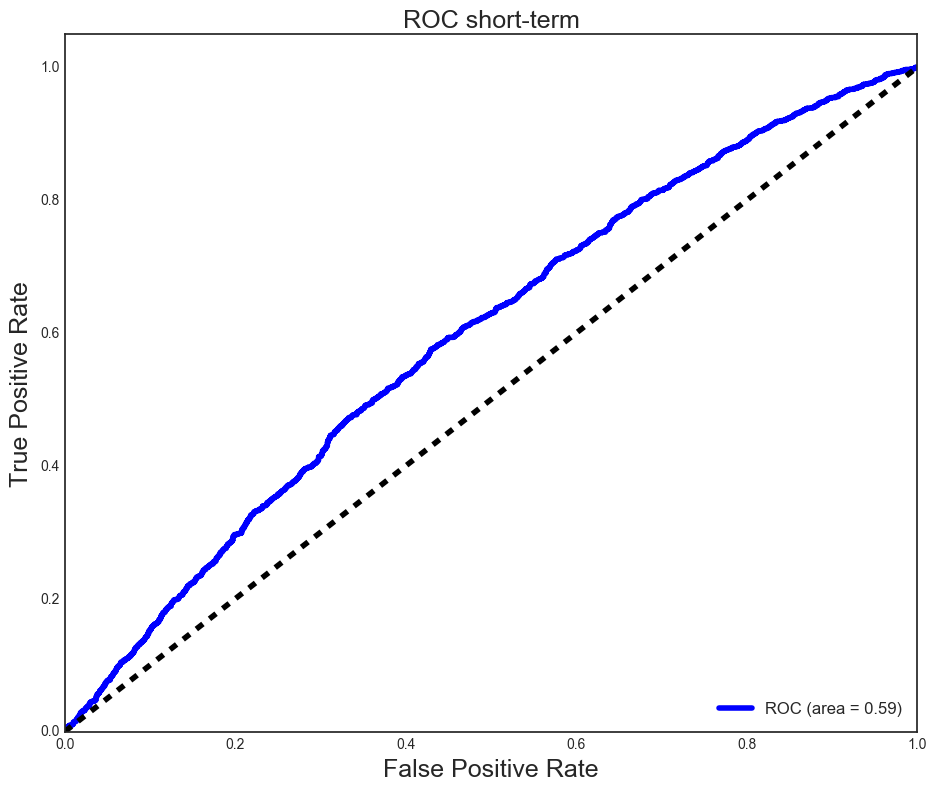

In [327]:
logreg = LogisticRegression(random_state=77)
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)


# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (fatality)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' short-term', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')
    
Y_score = logreg.decision_function(X_test)
plot_roc(y_test, Y_score)

Ew.

Okay, let's hit a Gridsearch

In [328]:
logreg = LogisticRegression(solver='liblinear')
C_vals = np.logspace(-5,1,50)
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, cv=5)
gs.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...    2.44205e+00,   3.23746e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [329]:
gs.best_params_

{'C': 2.4420530945486498, 'penalty': 'l2'}

In [330]:
logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X_train, y_train)


cv_pred = cv_model.predict(X_test)

cm = confusion_matrix(y_test, cv_pred, labels=logreg.classes_)

cm = pd.DataFrame(cm, columns=logreg.classes_, index=logreg.classes_)

cm

,0.0,1.0
0.0,2062,569
1.0,1413,665
